In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from plotting_tools import * 

In [2]:
%config InlineBackend.print_figure_kwargs = {'dpi': 110, 'bbox_inches': 'tight'}

In [3]:
experiment_series ="pop8"
precipitation_setting = "Rain"
decay_setting = "decay"

plot_path = f"../plots/{experiment_series}/concentration"
os.makedirs(plot_path, exist_ok=True)

In [4]:
# Load the data
result_path = f"../../preprocessing/preprocessed_data/{experiment_series}"

df = pd.read_csv(f"{result_path}/substances/{decay_setting}_{precipitation_setting}_output_scaled.csv")
df["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df["time_in_minutes"], unit="min")

In [5]:
df_base = pd.read_csv(f"{result_path}/substances/{"no_decay"}_{"noRain"}_output_scaled.csv")
df_base["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_base["time_in_minutes"], unit="min")
df_base = df_base[df_base.variable=="COV19"]
df_base["location"] = df_base.manhole.apply(lambda x: manhole_names[x] if x in manhole_names else x)

In [6]:
df = df.loc[df.variable=="COV19"]
df["location"] = df.manhole.apply(lambda x: manhole_names[x] if x in manhole_names else x)

In [7]:
df.head()

,time_in_minutes,variable,value,manhole,time_in_days,simulation_id,Date,location
0,15,COV19,0.0,MUC012,0.010417,1,2020-03-02 00:15:00,N_Uc
1,30,COV19,0.0,MUC012,0.020833,1,2020-03-02 00:30:00,N_Uc
2,45,COV19,0.0,MUC012,0.031250,1,2020-03-02 00:45:00,N_Uc
3,60,COV19,0.0,MUC012,0.041667,1,2020-03-02 01:00:00,N_Uc
4,75,COV19,0.0,MUC012,0.052083,1,2020-03-02 01:15:00,N_Uc


In [8]:
def simulate_sampling_strategies(df_COV_sim):
    df = df_COV_sim.copy()
    df["month"]= [el.month for el in df["Date"]]
    df["day"]= [el.day for el in df["Date"]]
    df["hour"] = [el.hour for el in df["Date"]]

    # get hourly measurements
    df = df.loc[df.time_in_minutes.mod(60) == 0,:]

    # calculate 24h samples
    df_24h = df.groupby(["location", "simulation_id", "day", "month"])[["value", "hour", "time_in_days", "Date"]].mean().reset_index().rename(columns={"value": "24h_sample"})
    # only consider 24h samples with 24h of data (i.e. remove first and last day of observations)
    df_24h = df_24h.loc[df_24h.hour==11.5, ["location", "simulation_id", "time_in_days", "day", "24h_sample", "Date"]]
    df_24h["time_in_days"] = df_24h["time_in_days"] + 1.5/24 # plot at 14:00

    # extract morning sample column
    df_morning_sample = df.loc[df.hour==10,:].rename(columns={"value": "morning_sample"}).loc[:,  ["Date", "time_in_days", "location", "simulation_id", "morning_sample"]]

    # combine everything
    df_measurements = pd.merge(df, pd.merge(df_24h, df_morning_sample, on=["location", "simulation_id", "Date", "time_in_days"], how="outer"), on=["location", "simulation_id", "Date", "time_in_days"], how="outer")
    df_measurements.rename({"value": "COVID19"}, axis=1, inplace=True)
    return df_measurements

In [9]:
df_measurements = simulate_sampling_strategies(df)
df_sampling = pd.melt(df_measurements, id_vars=["Date", "location", "simulation_id"], value_vars=["COVID19", "morning_sample", "24h_sample"]).dropna()

### Metrics

In [10]:
df_sampling.head()

,Date,location,simulation_id,variable,value
0,2020-03-02 01:00:00,C_U,1,COVID19,129.085094
1,2020-03-02 02:00:00,C_U,1,COVID19,161.594593
2,2020-03-02 03:00:00,C_U,1,COVID19,181.268596
3,2020-03-02 04:00:00,C_U,1,COVID19,194.891312
4,2020-03-02 05:00:00,C_U,1,COVID19,205.904873


In [11]:
df_sampling.Date.describe()

count                          4064700
mean     2020-04-17 00:49:20.853199360
min                2020-03-02 01:00:00
25%                2020-03-25 01:00:00
50%                2020-04-17 01:00:00
75%                2020-05-10 01:00:00
max                2020-06-02 00:00:00
Name: Date, dtype: object

In [12]:
location = "S_M2"

In [13]:
def get_metrics_24h_sample(location, min_date="2020-03-02", max_date="2020-06-02"):
    metric_24h_sample = df_sampling.loc[df_sampling.variable.isin(["24h_sample"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
    metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.location==location]
    df_base_sub = df_base.loc[df_base.variable=="COV19", ["Date", "location", "simulation_id", "value", "variable"]].copy()
    df_base_sub = df_base_sub.loc[df_base_sub.location==location]
    metric_24h_sample = pd.concat([metric_24h_sample, df_base_sub])

    metric_24h_sample = (
        metric_24h_sample
        .pivot(index=["Date", "simulation_id"], columns="variable", values="value")
        .reset_index()
        .sort_values(["simulation_id", "Date"])
    )

    # --- interpolate first (per simulation) ---
    metric_24h_sample["24h_sample"] = (
        metric_24h_sample
        .groupby("simulation_id", group_keys=False)["24h_sample"]
        .apply(lambda s: s.interpolate(method="linear"))
    )

    # ensure interpolation is only within observation window
    cutoff = pd.Timestamp("2020-06-01 11:30")
    metric_24h_sample.loc[metric_24h_sample["Date"] > cutoff, "24h_sample"] = np.nan

    # keep on-the-hour stamps before averaging
    #on_the_hour = metric_24h_sample.loc[metric_24h_sample["Date"].dt.minute == 0].copy()

    # --- then average across simulations ---
    metric_24h_sample = (
        metric_24h_sample
        .groupby("Date")[["24h_sample", "COV19"]]
        .mean()
        .sort_index()
        .reset_index()
    )

    metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.Date >= min_date]
    metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.Date <= max_date]

    # MAE on the averaged series
    metric_24h_sample["MAE"] = (metric_24h_sample["24h_sample"] - metric_24h_sample["COV19"]).abs()

    return metric_24h_sample

def get_metric_morning_sample(location, min_date="2020-03-02", max_date="2020-06-02"):
    metric_morning_sample = df_sampling.loc[df_sampling.variable.isin(["morning_sample"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
    metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.location==location]
    df_base_sub = df_base.loc[df_base.variable=="COV19", ["Date", "location", "simulation_id", "value", "variable"]].copy()
    df_base_sub = df_base_sub.loc[df_base_sub.location==location]
    metric_morning_sample = pd.concat([metric_morning_sample, df_base_sub])

    metric_morning_sample = (
        metric_morning_sample
        .pivot(index=["Date", "simulation_id"], columns="variable", values="value")
        .reset_index()
        .sort_values(["simulation_id", "Date"])
    )

    # --- interpolate first (per simulation) ---
    metric_morning_sample["morning_sample"] = (
        metric_morning_sample
        .groupby("simulation_id", group_keys=False)["morning_sample"]
        .apply(lambda s: s.interpolate(method="linear"))
    )

    # ensure interpolation is only within observation window
    cutoff = pd.Timestamp("2020-06-01 10:00")
    metric_morning_sample.loc[metric_morning_sample["Date"] > cutoff, "morning_sample"] = np.nan

    # keep on-the-hour stamps before averaging
    #on_the_hour = metric_morning_sample.loc[metric_morning_sample["Date"].dt.minute == 0].copy()

    # --- then average across simulations ---
    metric_morning_sample = (
        metric_morning_sample
        .groupby("Date")[["morning_sample", "COV19"]]
        .mean()
        .sort_index()
        .reset_index()
    )

    metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.Date >= min_date]
    metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.Date <= max_date]

    # MAE on the averaged series
    metric_morning_sample["MAE"] = (metric_morning_sample["morning_sample"] - metric_morning_sample["COV19"]).abs()

    # metric_morning_sample.describe()
    return metric_morning_sample


In [14]:
def get_mse_metrics_24h_sample(location, min_date="2020-03-02", max_date="2020-06-02"):
    metric_24h_sample = df_sampling.loc[df_sampling.variable.isin(["24h_sample"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
    metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.location==location]
    df_base_sub = df_base.loc[df_base.variable=="COV19", ["Date", "location", "simulation_id", "value", "variable"]].copy()
    df_base_sub = df_base_sub.loc[df_base_sub.location==location]
    metric_24h_sample = pd.concat([metric_24h_sample, df_base_sub])

    metric_24h_sample = (
        metric_24h_sample
        .pivot(index=["Date", "simulation_id"], columns="variable", values="value")
        .reset_index()
        .sort_values(["simulation_id", "Date"])
    )

    # --- interpolate first (per simulation) ---
    metric_24h_sample["24h_sample"] = (
        metric_24h_sample
        .groupby("simulation_id", group_keys=False)["24h_sample"]
        .apply(lambda s: s.interpolate(method="linear"))
    )

    # ensure interpolation is only within observation window
    cutoff = pd.Timestamp("2020-06-01 11:30")
    metric_24h_sample.loc[metric_24h_sample["Date"] > cutoff, "24h_sample"] = np.nan

    # keep on-the-hour stamps before averaging
    #on_the_hour = metric_24h_sample.loc[metric_24h_sample["Date"].dt.minute == 0].copy()

    # --- then average across simulations ---
    metric_24h_sample = (
        metric_24h_sample
        .groupby("Date")[["24h_sample", "COV19"]]
        .mean()
        .sort_index()
        .reset_index()
    )

    metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.Date >= min_date]
    metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.Date <= max_date]

    # MAE on the averaged series
    metric_24h_sample["MSE"] = (metric_24h_sample["24h_sample"] - metric_24h_sample["COV19"])**2

    return metric_24h_sample

def get_mse_metric_morning_sample(location, min_date="2020-03-02", max_date="2020-06-02"):
    metric_morning_sample = df_sampling.loc[df_sampling.variable.isin(["morning_sample"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
    metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.location==location]
    df_base_sub = df_base.loc[df_base.variable=="COV19", ["Date", "location", "simulation_id", "value", "variable"]].copy()
    df_base_sub = df_base_sub.loc[df_base_sub.location==location]
    metric_morning_sample = pd.concat([metric_morning_sample, df_base_sub])

    metric_morning_sample = (
        metric_morning_sample
        .pivot(index=["Date", "simulation_id"], columns="variable", values="value")
        .reset_index()
        .sort_values(["simulation_id", "Date"])
    )

    # --- interpolate first (per simulation) ---
    metric_morning_sample["morning_sample"] = (
        metric_morning_sample
        .groupby("simulation_id", group_keys=False)["morning_sample"]
        .apply(lambda s: s.interpolate(method="linear"))
    )

    # ensure interpolation is only within observation window
    cutoff = pd.Timestamp("2020-06-01 10:00")
    metric_morning_sample.loc[metric_morning_sample["Date"] > cutoff, "morning_sample"] = np.nan

    # keep on-the-hour stamps before averaging
    #on_the_hour = metric_morning_sample.loc[metric_morning_sample["Date"].dt.minute == 0].copy()

    # --- then average across simulations ---
    metric_morning_sample = (
        metric_morning_sample
        .groupby("Date")[["morning_sample", "COV19"]]
        .mean()
        .sort_index()
        .reset_index()
    )

    metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.Date >= min_date]
    metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.Date <= max_date]

    # MAE on the averaged series
    metric_morning_sample["MSE"] = (metric_morning_sample["morning_sample"] - metric_morning_sample["COV19"])**2
    # metric_morning_sample.describe()
    return metric_morning_sample


In [17]:
MSE_all = pd.DataFrame()
MAE_all = pd.DataFrame()
for location in df_sampling.location.unique():
    metric_24h_sample = get_mse_metrics_24h_sample(location)
    metric_morning_sample = get_mse_metric_morning_sample(location)
    MSE_df = pd.DataFrame({"morning_sample": metric_morning_sample["MSE"], "24h_sample": metric_24h_sample["MSE"]})
    MSE_df_d = MSE_df.describe().reset_index()
    MSE_df_d["location"] = location
    MSE_all = pd.concat([MSE_all, MSE_df_d], ignore_index=True)
    metric_24h_sample = get_metrics_24h_sample(location)
    metric_morning_sample = get_metric_morning_sample(location)
    MAE_df = pd.DataFrame({"morning_sample": metric_morning_sample["MAE"], "24h_sample": metric_24h_sample["MAE"]})
    MAE_df_d = MAE_df.describe().reset_index()
    MAE_df_d["location"] = location
    MAE_all = pd.concat([MAE_all, MAE_df_d], ignore_index=True)

    print(location)
    """
    fig, ax = plt.subplots(figsize = (6,3), dpi=300)
    sns.boxplot(data=MAE_df.loc[(MAE_df["24h_sample"].notna())&(MAE_df["morning_sample"].notna())], linewidth=1.5, palette=[red, teal])
    ax.set_ylabel(f"Absolute error")
    ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)
    ax.tick_params(axis='y')
    ax.set_yscale('log')
    plt.tight_layout()
    fig.savefig(f"{plot_path}/sampling_strategy/sampling_strategy_{location}_mae.png", bbox_inches="tight")
    """    


C_U
E_M
E_U
MUC486
N_D
N_Ua
N_Ub
N_Uc
Overall
SCE_D1
SCE_D2
S_M1
S_M2
S_M3
S_M4
S_Ua
S_Ub


In [19]:
pop_size = {'N_Ua': 7246,
                   'N_Ub': 7123,
                   'N_Uc': 12331,
                   'C_U': 8578,
                   'S_Ua': 21865,
                   'S_Ub': 28344,
                   'S_M1': 208384,
                   'S_M2': 546972,
                   'S_M3': 637134,
                   'S_M4':936099,
                   'E_U': 40185,
                   'E_M': 137475,
                   'N_D': 200421,
                   'SCE_D1': 1327986,
                   'SCE_D2': 1327986,
                   'Overall': 1528407}

pop_density = {'N_Ua': 1800.74,
                   'N_Ub': 6476.22,
                   'N_Uc': 1113.71,
                   'C_U': 2450.72,
                   'S_Ua': 4475.98,
                   'S_Ub': 4465.71,
                   'S_M1': 5975.66,
                   'S_M2': 7465.83,
                   'S_M3': 8038.12,
                   'S_M4':8026.06,
                   'E_U': 6846.07,
                   'E_M': 3757.39,
                   'N_D': 2015.63,
                   'SCE_D1': 6265.43,
                   'SCE_D2': 6265.43,
                   'Overall': 4908.37}

MAE_all["pop_size"] = MAE_all["location"].map(pop_size)
MAE_all["pop_density"] = MAE_all["location"].map(pop_density)

MSE_all["pop_size"] = MSE_all["location"].map(pop_size)
MSE_all["pop_density"] = MSE_all["location"].map(pop_density)

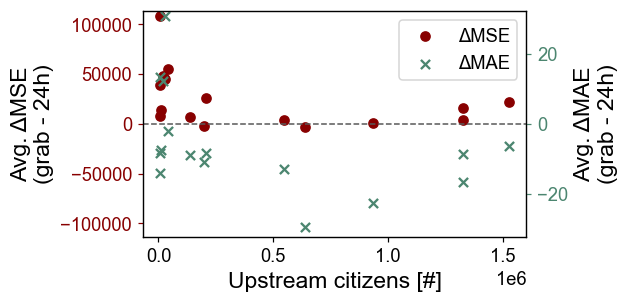

In [20]:
# MSE diff (left y-axis)
df_mse = MSE_all.loc[MSE_all["index"] == "mean"].sort_values("pop_size")
mse_diff = df_mse["morning_sample"] - df_mse["24h_sample"]

# MAE diff (right y-axis)
df_mae = MAE_all.loc[MAE_all["index"] == "mean"].sort_values("pop_size")
mae_diff = df_mae["morning_sample"] - df_mae["24h_sample"]

fig, ax1 = plt.subplots(figsize=(6, 3))

# Left axis: MSE
s1 = ax1.scatter(df_mse["pop_size"], mse_diff, label="ΔMSE", color=red)
ax1.set_xlabel("Upstream citizens [#]")
ax1.set_ylabel("Avg. ΔMSE\n(grab - 24h)")
#ax1.spines["left"].set_color(red)
ax1.tick_params(axis="y", colors=red)

# Right axis: MAE
ax2 = ax1.twinx()
s2 = ax2.scatter(df_mae["pop_size"], mae_diff, marker="x", label="ΔMAE", color=teal)
ax2.set_ylabel("Avg. ΔMAE\n(grab - 24h)")
#ax2.spines["right"].set_color(teal)
ax2.tick_params(axis="y", colors=teal)

# --- Center both y-axes around zero ---
ymax1 = max(abs(mse_diff).max(), abs(mse_diff).min())
ax1.set_ylim(-ymax1*1.05, ymax1*1.05)   

ymax2 = max(abs(mae_diff).max(), abs(mae_diff).min())
ax2.set_ylim(-ymax2*1.05, ymax2*1.05)

# --- Reference lines ---
ax1.axhline(0, color=dark_grey, linestyle="--", linewidth=1)   # horizontal y=0

# Combined legend
handles = [s1, s2]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="best")

plt.tight_layout()
plt.show()

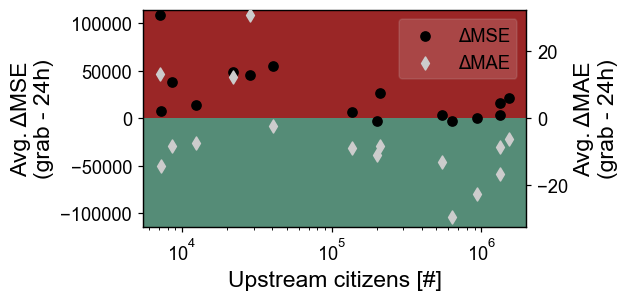

In [50]:
# MSE diff (left y-axis)
df_mse = MSE_all.loc[MSE_all["index"] == "mean"].sort_values("pop_size")
mse_diff = df_mse["morning_sample"] - df_mse["24h_sample"]

# MAE diff (right y-axis)
df_mae = MAE_all.loc[MAE_all["index"] == "mean"].sort_values("pop_size")
mae_diff = df_mae["morning_sample"] - df_mae["24h_sample"]

fig, ax1 = plt.subplots(figsize=(6, 3))

# Left axis: MSE
s1 = ax1.scatter(df_mse["pop_size"], mse_diff, label="ΔMSE", color=black, zorder=20)
ax1.set_xlabel("Upstream citizens [#]")
ax1.set_ylabel("Avg. ΔMSE\n(grab - 24h)")
#ax1.spines["left"].set_color(red)
# ax1.tick_params(axis="y", colors=red)
ax1.set_xscale('log')

# Right axis: MAE
ax2 = ax1.twinx()
s2 = ax2.scatter(df_mae["pop_size"], mae_diff, marker="d", label="ΔMAE", color=light_grey, zorder=20)
ax2.set_ylabel("Avg. ΔMAE\n(grab - 24h)")
#ax2.spines["right"].set_color(teal)
# ax2.tick_params(axis="y", colors=teal)
ax2.set_xscale('log')

# --- Make twin axis background transparent so shading shows through ---
ax2.patch.set_visible(False)

# --- Center both y-axes around zero ---
ymax1 = max(abs(mse_diff).max(), abs(mse_diff).min())
ax1.set_ylim(-ymax1*1.05, ymax1*1.05)   

ymax2 = max(abs(mae_diff).max(), abs(mae_diff).min())
ax2.set_ylim(-ymax2*1.05, ymax2*1.05)

# --- Shading for positive (>0) and negative (<0) regions ---
ylim1_low, ylim1_high = ax1.get_ylim()
ax1.axhspan(0, ylim1_high, facecolor=red, alpha=0.85, zorder=0)
ax1.axhspan(ylim1_low, 0, facecolor=teal, alpha=0.95, zorder=0)

# --- Reference lines ---
#ax1.axhline(0, color=dark_grey, linestyle="--", linewidth=1)   # horizontal y=0

# Combined legend
handles = [s1, s2]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="best", framealpha=0.15)

plt.tight_layout()
plt.show()
fig.savefig(f"{plot_path}/sampling_strategy/mse_mae_difference_vs_population.png", bbox_inches="tight", dpi=300)


### Boxplot of Metrics

In [ ]:
location = "S_M2"

In [50]:
metric_24h_sample = get_metrics_24h_sample(location)
metric_morning_sample = get_metric_morning_sample(location)
MAE_df = pd.DataFrame({"morning_sample": metric_morning_sample["MAE"], "24h_sample": metric_24h_sample["MAE"]})

/tmp/ipykernel_98032/243566927.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)


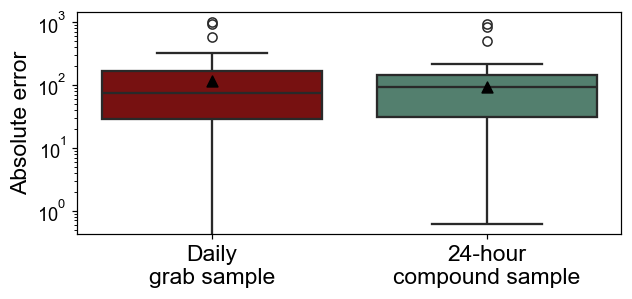

In [121]:
fig, ax = plt.subplots(figsize = (6,3), dpi=300)
sns.boxplot(data=MAE_df.loc[(MAE_df["24h_sample"].notna())&(MAE_df["morning_sample"].notna())], linewidth=1.5, palette=[red, teal])
means = MAE_df.mean()
ax.scatter(
    x=np.arange(len(means)), 
    y=means,
    marker='^',      # Triangle marker
    color='black',   # Marker colour
    s=50,            # Marker size
    zorder=3         # Draw above boxplot
)

ax.set_ylabel(f"Absolute error")
ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)
ax.tick_params(axis='y')
ax.set_yscale('log')
plt.tight_layout()

##### comparison with same decay/rain setting

In [14]:
metric_24h_sample = df_sampling.loc[df_sampling.variable.isin(["24h_sample", "COVID19"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.location==location]

In [15]:
metric_24h_sample = df_sampling.loc[df_sampling.variable.isin(["24h_sample", "COVID19"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.location==location]
metric_24h_sample = metric_24h_sample.pivot(index=["Date", "simulation_id"], columns="variable", values="value").reset_index()

# take average across simulations
metric_24h_sample = metric_24h_sample.groupby("Date")[["24h_sample", "COVID19"]].mean().sort_index().reset_index()

# interpolate linearly between 24h samples
metric_24h_sample["24h_sample"] = metric_24h_sample["24h_sample"].interpolate(method="linear")
# ensure that linear interpolation happens only between "observations"
metric_24h_sample.loc[metric_24h_sample.Date>"2020-06-01 11:30", "24h_sample"] = np.nan
metric_24h_sample["minute"] = metric_24h_sample["Date"].dt.minute
metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.minute==0]

metric_24h_sample["MAE"] = np.abs(metric_24h_sample["24h_sample"] - metric_24h_sample["COVID19"])
metric_24h_sample.describe()

variable,Date,24h_sample,COVID19,minute,MAE
count,2208,2160.000000,2208.000000,2208.0,2160.000000
mean,2020-04-17 00:30:00,1168.928423,1145.653775,0.0,75.541664
min,2020-03-02 01:00:00,60.493621,29.095937,0.0,0.003222
25%,2020-03-25 00:45:00,438.293495,397.673237,0.0,7.031059
50%,2020-04-17 00:30:00,836.988171,815.609308,0.0,21.443347
75%,2020-05-10 00:15:00,1535.564215,1506.435513,0.0,59.915100
max,2020-06-02 00:00:00,4950.082535,5009.374386,0.0,1450.471159
std,NaN,1061.711681,1093.052958,0.0,160.182180


In [17]:
metric_morning_sample = df_sampling.loc[df_sampling.variable.isin(["morning_sample", "COVID19"]), ["Date", "location", "simulation_id", "value", "variable"]].copy()
metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.location==location]
metric_morning_sample = metric_morning_sample.pivot(index=["Date", "simulation_id"], columns="variable", values="value").reset_index()

# take average across simulations
metric_morning_sample = metric_morning_sample.groupby("Date")[["morning_sample", "COVID19"]].mean().sort_index().reset_index()

# interpolate linearly between 24h samples
metric_morning_sample["morning_sample"] = metric_morning_sample["morning_sample"].interpolate(method="linear")
# ensure that linear interpolation happens only between "observations"
metric_morning_sample.loc[metric_morning_sample.Date>"2020-06-02 10:00", "morning_sample"] = np.nan

metric_morning_sample["MAE"] = np.abs(metric_morning_sample["morning_sample"] - metric_morning_sample["COVID19"])
metric_morning_sample.describe()

variable,Date,morning_sample,COVID19,MAE
count,2208,2199.000000,2208.000000,2199.000000
mean,2020-04-17 00:30:00,1160.761916,1145.653775,69.667337
min,2020-03-02 01:00:00,38.003995,29.095937,0.000000
25%,2020-03-25 00:45:00,406.041676,397.673237,3.777359
50%,2020-04-17 00:30:00,849.548244,815.609308,12.007251
75%,2020-05-10 00:15:00,1520.762912,1506.435513,37.803464
max,2020-06-02 00:00:00,4938.274641,5009.374386,1812.598411
std,NaN,1067.747115,1093.052958,174.291461


In [18]:
MAE_df = pd.DataFrame({"morning_sample": metric_morning_sample["MAE"], "24h_sample": metric_24h_sample["MAE"]})
MAE_df.describe()

,morning_sample,24h_sample
count,2199.000000,2160.000000
mean,69.667337,75.541664
std,174.291461,160.182180
min,0.000000,0.003222
25%,3.777359,7.031059
50%,12.007251,21.443347
75%,37.803464,59.915100
max,1812.598411,1450.471159


/tmp/ipykernel_114746/355822953.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)


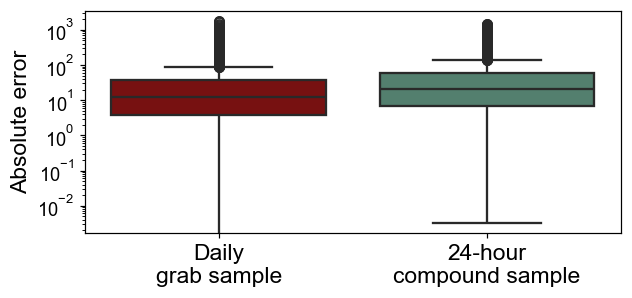

In [20]:
import numpy as np

fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

# Boxplot
sns.boxplot(data=MAE_df, linewidth=1.5, palette=[red, teal], ax=ax)

# Calculate and plot the means as small triangles
"""means = MAE_df.mean()
ax.scatter(
    x=np.arange(len(means)), 
    y=means,
    marker='^',      # Triangle marker
    color=brown,   # Marker colour
    s=50,            # Marker size
    zorder=3         # Draw above boxplot
)
"""
# Labels and style
ax.set_ylabel("Absolute error")
ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)
ax.tick_params(axis='y')
ax.set_yscale('log')

plt.tight_layout()
fig.savefig(f"{plot_path}/sampling_strategy/sampling_strategy_{location}_mae_same_setting.png", bbox_inches="tight")


/tmp/ipykernel_45258/1030015164.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)


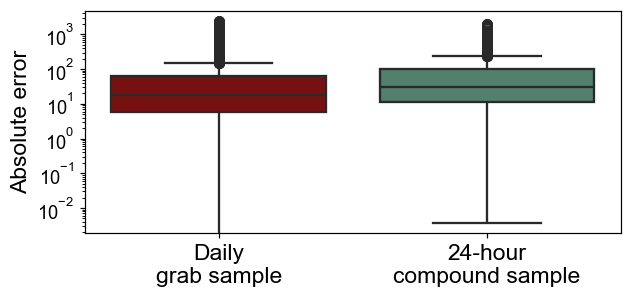

In [ ]:
fig, ax = plt.subplots(figsize = (6,3), dpi=300)
sns.boxplot(data=MAE_df, linewidth=1.5, palette=[red, teal])
ax.set_ylabel(f"Absolute error")
ax.set_xticklabels(["Daily\ngrab sample", "24-hour\ncompound sample"], size=15)
ax.tick_params(axis='y')
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(f"{plot_path}/sampling_strategy/sampling_strategy_{location}_mae.png", bbox_inches="tight")


### Plot Timeseries

In [ ]:
def plot_sampling_strategy(station):
    df_curr = df_sampling.loc[df_sampling.location==station, :]
    df_curr = df_curr.loc[(df_curr.Date>"2020-03-08 08:00:00")&(df_curr.Date<"2020-03-14 15:00:00")]
    #df_curr = df_curr.loc[(df_curr.Date>"2020-03-08 08:00:00")&(df_curr.Date<"2020-04-14 15:00:00")]
    #df_curr = df_curr.loc[(df_curr.Date>"2020-04-08 08:00:00")&(df_curr.Date<"2020-06-14 15:00:00")]

    # Calculate and add 90percentiles as error bars
    ci_morning = df_curr[df_curr.variable == "morning_sample"].groupby("Date")['value'].agg([lambda x: np.mean(x), lambda x: np.percentile(x, 5), lambda x: np.percentile(x, 95)])
    ci_morning.columns = ['mean', 'p5', 'p95']

    ci_24h = df_curr[df_curr.variable == "24h_sample"].groupby("Date")['value'].agg([lambda x: np.mean(x), lambda x: np.percentile(x, 5), lambda x: np.percentile(x, 95)])
    ci_24h.columns = ['mean', 'p5', 'p95']


    # Use Seaborn's default 95% confidence interval with error bars
    #fig, ax = plt.subplots(figsize=(7, 2.7), dpi=300) 
    fig, ax = plt.subplots(figsize=(17, 2.7), dpi=300) 
    

    ax2 = ax.twinx()
    sns.lineplot(df_curr.loc[df_curr.variable == "morning_sample", :], ax=ax2, x="Date", y="value", errorbar=None, color=teal, marker="o", label="Daily grab sample")
    sns.lineplot(df_curr.loc[df_curr.variable == "24h_sample", :], ax=ax2, x="Date", y="value", errorbar=None, color=red, marker="o", label="24-hour compound sample")
    sns.lineplot(df_curr.loc[df_curr.variable == "COVID19", :], ax=ax, x="Date", y="value", color=blue, label="Reference", legend=False, alpha=0.6, estimator=np.mean, errorbar=("pi", 90))

    ax2.errorbar(ci_morning.index, ci_morning['mean'], 
                yerr=[ci_morning['mean'] - ci_morning['p5'], ci_morning['p95'] - ci_morning['mean']], 
                fmt='o', color=teal, capsize=4)

    ax2.errorbar(ci_24h.index, ci_24h['mean'], 
                yerr=[ci_24h['mean'] - ci_24h['p5'], ci_24h['p95'] - ci_24h['mean']], 
                fmt='o', color=red, capsize=4)

    # Set x-labels for bottom row only
    #for ax in axes[-4:]:
    ax.set_xlabel("")

    import matplotlib.dates as mdates

    # Set major ticks every 7 days
    seven_days = mdates.DayLocator(interval=1)
    #for ax in axes:
    ax.xaxis.set_major_locator(seven_days)

    ax.set(ylim=(-100, df_curr.value.max()+100))
    ax2.set(ylim=(-100, df_curr.value.max()+100))
    ax2.set_ylabel(None)
    ax2.set_yticks([])
    ax.set_ylabel('Virus levels\n[copies/l]')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))  # Format without year
    plt.tight_layout()

    fig.savefig(f"{plot_path}/sampling_strategy/sampling_strategy_{station}.png", bbox_inches="tight")


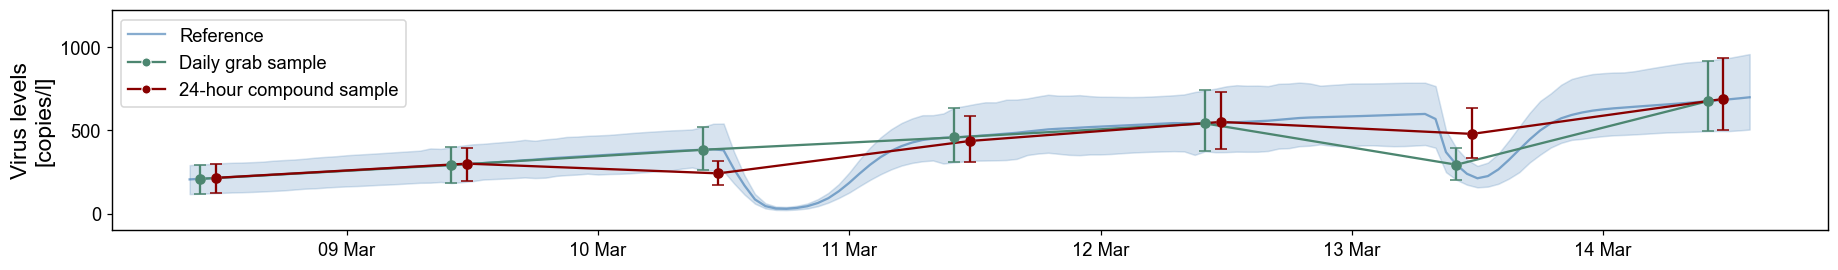

In [ ]:
plot_sampling_strategy("S_M2")

In [ ]:
df_sampling.location.unique()

array(['C_U', 'E_M', 'E_U', 'MUC486', 'N_D', 'N_Ua', 'N_Ub', 'N_Uc',
       'Overall', 'SCE_D1', 'SCE_D2', 'S_M1', 'S_M2', 'S_M3', 'S_M4',
       'S_Ua', 'S_Ub'], dtype=object)

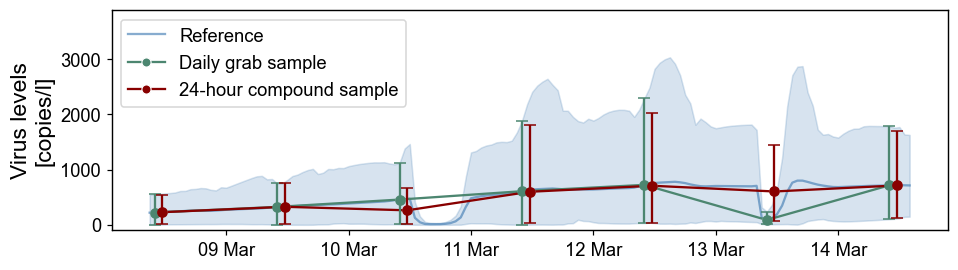

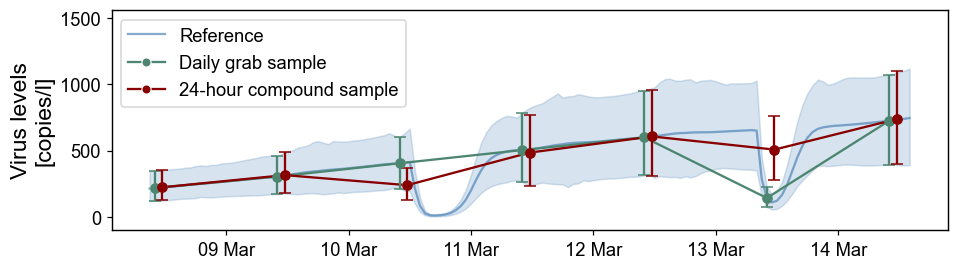

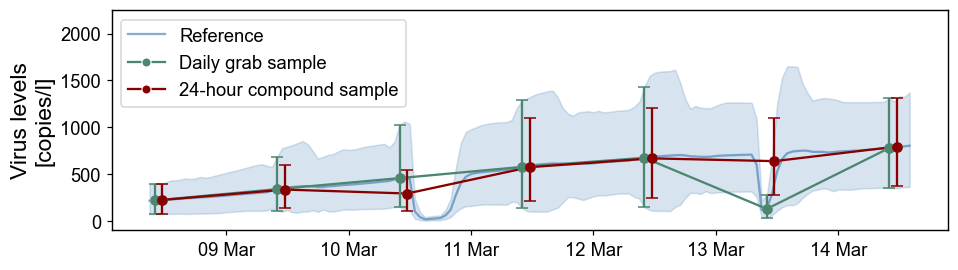

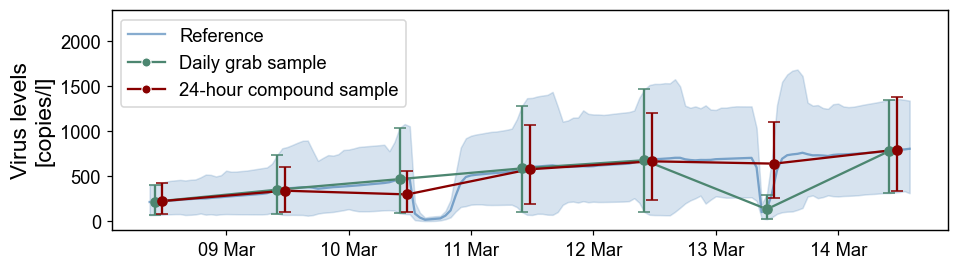

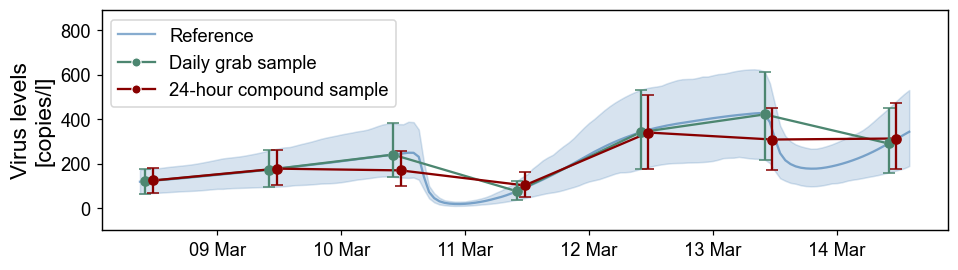

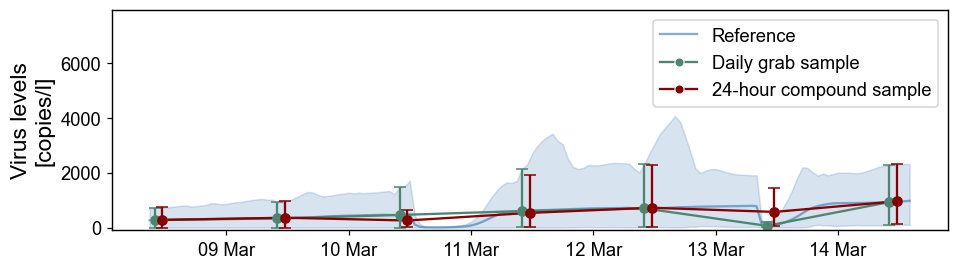

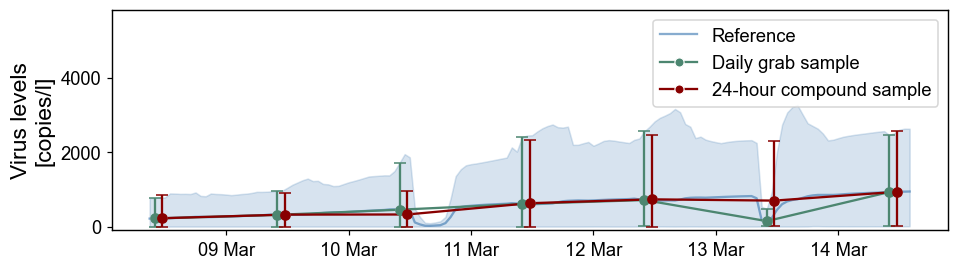

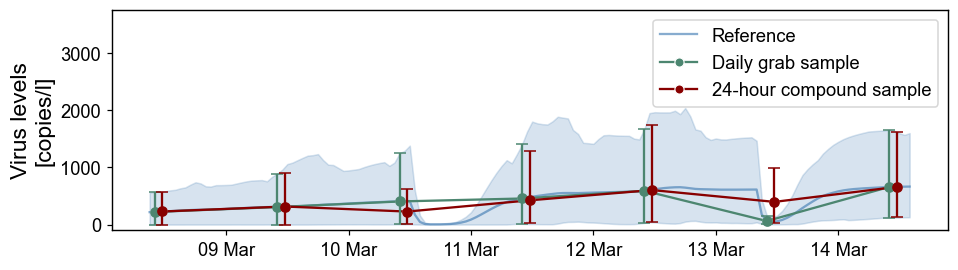

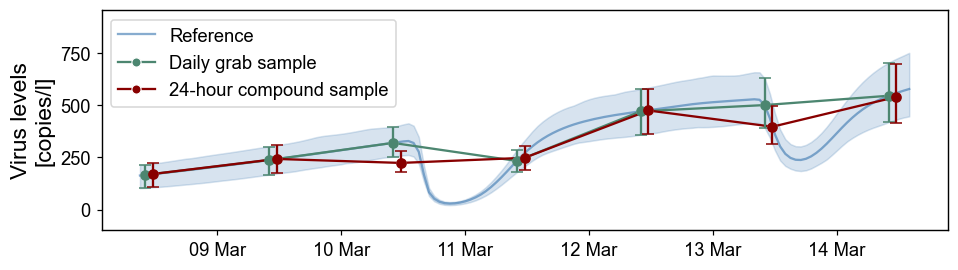

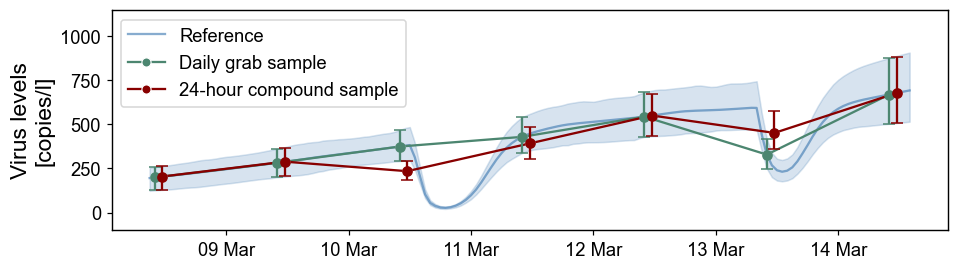

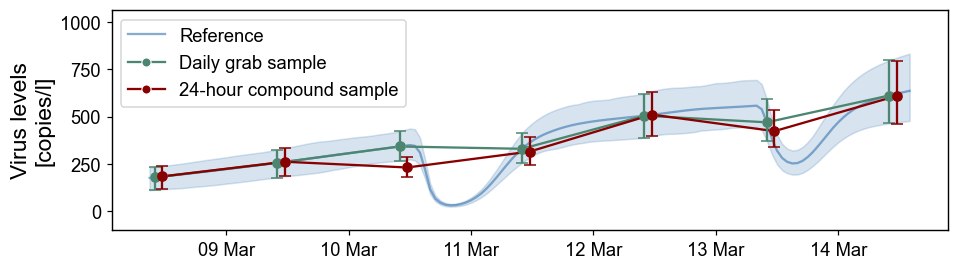

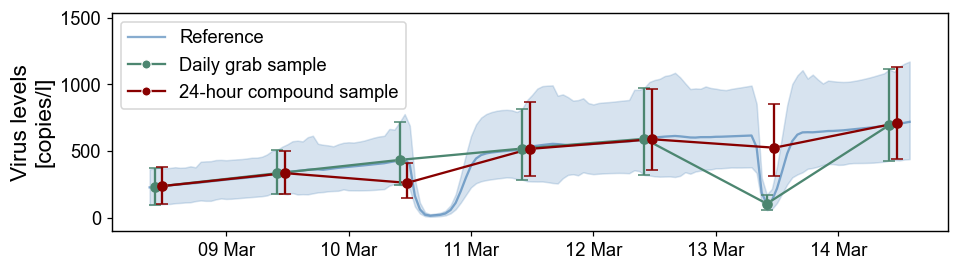

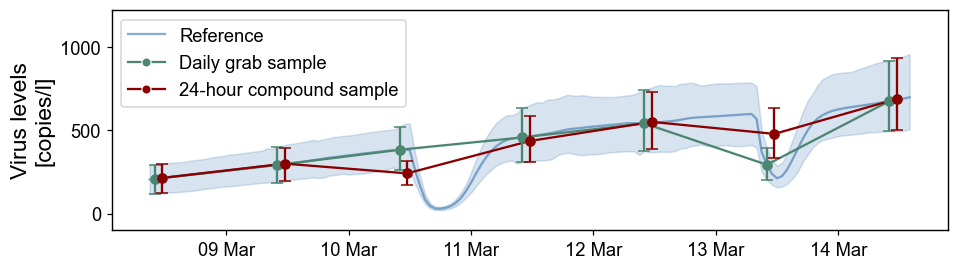

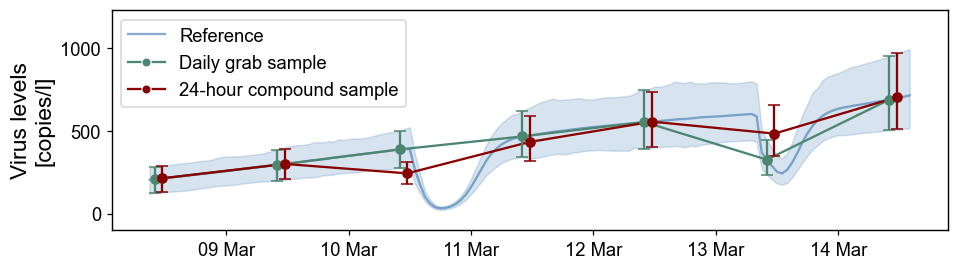

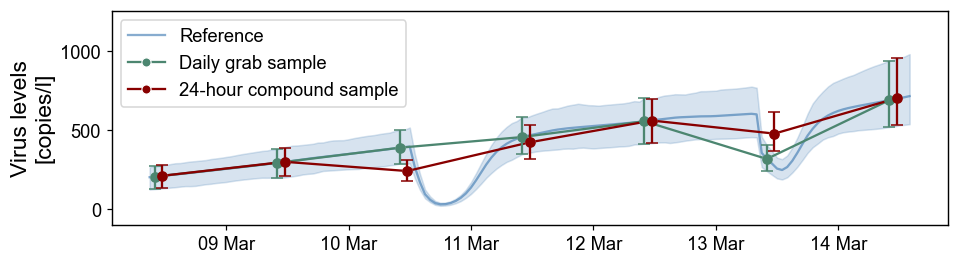

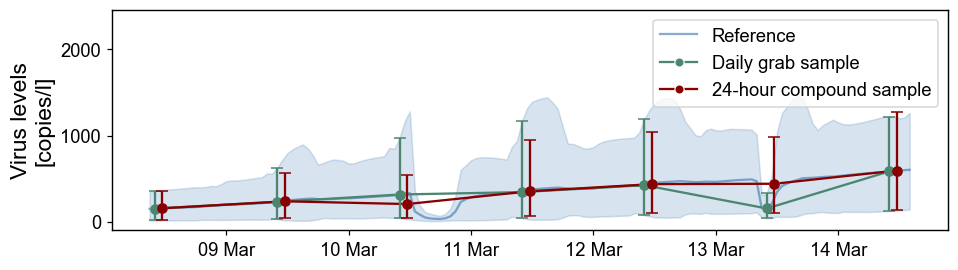

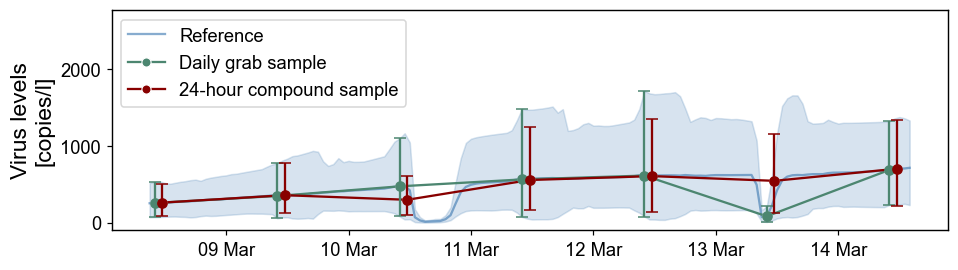

In [ ]:
for station in df_sampling.location.unique():
    plot_sampling_strategy(station)

In [ ]:
df_sampling.location.unique()

array(['C_U', 'E_M', 'E_U', 'MUC486', 'N_D', 'N_Ua', 'N_Ub', 'N_Uc',
       'Overall', 'SCE_D1', 'SCE_D2', 'S_M1', 'S_M2', 'S_M3', 'S_M4',
       'S_Ua', 'S_Ub'], dtype=object)